### Run this once (preparing and storing audio data set paths)

In [ ]:
import os
import moviepy.editor as mp
import pandas as pd
import shutil

vid_data_set_path = "D:\Engineering\Projects\Violence detection\Dataset_2"
audio_saving_path = "D:\Engineering\Projects\Violence detection\Dataset_2_aud"
# Saving data paths to CSVs
csv_path = "D:\Engineering\Projects\Violence detection\Codes\CSVs_2_aud\Dataset_2"

vid_dataset_sub_folder_paths = os.listdir(vid_data_set_path)

train_aud_bin= []
test_aud_bin = []
for item in vid_dataset_sub_folder_paths:
    all_vids = os.listdir(vid_data_set_path+"/"+item)
    bin=[]
    path = os.path.join(audio_saving_path,item)
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)           # Removes all the subdirectories!
        os.makedirs(path)

    for vid in all_vids:
        clip = mp.VideoFileClip(str(vid_data_set_path+"/"+item)+"/"+vid)
        aud_file_path = os.path.join(path,str(os.path.splitext(vid)[0]+".mp3")) # Extracting the video name (without.mp4) and changing it to .mp3
        #and adding to the base path
        #print(aud_file_path)
        clip.audio.write_audiofile(aud_file_path)
        bin.append((item,aud_file_path))
    l = int(len(bin)*0.8)   # 80% for training and rest is test or validation
    train_aud_bin.extend(bin[:l])
    test_aud_bin.extend(bin[l:])

df_aud_train = pd.DataFrame(data= train_aud_bin,columns=['tag','Name'])
print(f"Train set size = {len(df_aud_train)}")
print(df_aud_train.head())
df_aud_test = pd.DataFrame(data= test_aud_bin,columns=['tag','Name'])
print(f"Test set size = {len(df_aud_test)}")
print(df_aud_test.head())


# Saving to csv
df_aud_train=df_aud_train.loc[:,['Name','tag']]
df_aud_train.to_csv(os.path.join(csv_path,'train.csv'))
df_aud_test=df_aud_test.loc[:,['Name','tag']]
df_aud_test.to_csv(os.path.join(csv_path,'test.csv'))

df_aud_train.sample(5)

### Load dataframes from the csv
(csvs have being prepared in the audio_classifier first code)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers, models, losses
from keras.layers import Dense, Dropout
import cv2 as cv
import os
import librosa

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print("gpu")
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

gpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the dataframes and extracting values (paths and labels)

csv_path= "/content/drive/MyDrive/Codes/CSVs/Audio_model"

if 'csv_path' not in vars():
    csv_path ="/content/drive/MyDrive/Codes/CSVs/Audio_model"

loaded_train_df = pd.read_csv(os.path.join(csv_path,"train.csv"),usecols=['Name','tag'])

loaded_test_df = pd.read_csv(os.path.join(csv_path,"test.csv"),usecols=['Name','tag'])

loaded_train_df.head()

,Name,tag
0,/content/drive/MyDrive/Multi Class Dataset Aud...,Car Accidents
1,/content/drive/MyDrive/Multi Class Dataset Aud...,Car Accidents
2,/content/drive/MyDrive/Multi Class Dataset Aud...,Car Accidents
3,/content/drive/MyDrive/Multi Class Dataset Aud...,Car Accidents
4,/content/drive/MyDrive/Multi Class Dataset Aud...,Car Accidents


### Upsampling and one hot encoding

In [5]:
print(loaded_train_df['tag'].value_counts())
print(loaded_test_df['tag'].value_counts())
max_category_size = np.max(loaded_train_df['tag'].value_counts())
categories = pd.unique(loaded_train_df['tag'])

#loaded_train_df['tag'].value_counts()[categories[0]]
val_counts =loaded_train_df['tag'].value_counts()
max_category_size = np.max(val_counts)
print(max_category_size)

tag
Nonviolence      444
Fighting         444
Shooting         327
Abuse            180
Car Accidents    165
Explosion        138
Riots             86
Name: count, dtype: int64
tag
Fighting         112
Nonviolence      111
Shooting          82
Abuse             46
Car Accidents     42
Explosion         35
Riots             22
Name: count, dtype: int64
444


In [6]:
# upsampling

from sklearn.utils import resample

def upsample(data_frame):
    val_counts =data_frame['tag'].value_counts()
    max_category_size = np.max(val_counts)
    upsampled_full_df=[]
    for category, subset_df in data_frame.groupby('tag'):
        if val_counts[category] < max_category_size:
            subset_df = resample(subset_df,
                                    replace=True,                    # Sample with replacement
                                    n_samples=max_category_size,     # Majority class size
                                    random_state=42)
        upsampled_full_df.append(subset_df)
    return pd.concat(upsampled_full_df).reset_index(drop=True)

upsampled_train_df = upsample(loaded_train_df)
upsampled_test_df = upsample(loaded_test_df)
# shuffle the DataFrame rows
upsampled_train_df = upsampled_train_df.sample(frac=1).reset_index(drop=True)
upsampled_test_df = upsampled_test_df.sample(frac=1).reset_index(drop=True)

print(f"Before upsampling train :- {loaded_train_df.shape}")
print(f"Before upsampling test :- {loaded_test_df.shape}")
print(f"After upsampling test :- {upsampled_train_df.shape}")
print(f"After upsampling test :- {upsampled_test_df.shape}")
print(upsampled_train_df['tag'].value_counts())
print(upsampled_test_df['tag'].value_counts())


Before upsampling train :- (1784, 2)
Before upsampling test :- (450, 2)
After upsampling test :- (3108, 2)
After upsampling test :- (784, 2)
tag
Shooting         444
Explosion        444
Nonviolence      444
Car Accidents    444
Fighting         444
Abuse            444
Riots            444
Name: count, dtype: int64
tag
Nonviolence      112
Abuse            112
Car Accidents    112
Fighting         112
Shooting         112
Explosion        112
Riots            112
Name: count, dtype: int64


In [7]:
# Apply one hot encoding

print(upsampled_train_df.head())
upsampled_train_df= pd.get_dummies(upsampled_train_df.loc[:,['Name','tag']], columns=['tag'])
upsampled_train_df.iloc[:,1:]= upsampled_train_df.iloc[:,1:].astype(np.uint8)#(np.float16)
print(upsampled_train_df.head())

print(upsampled_test_df.head())
upsampled_test_df= pd.get_dummies(upsampled_test_df.loc[:,['Name','tag']], columns=['tag'])
upsampled_test_df.iloc[:,1:]= upsampled_test_df.iloc[:,1:].astype(np.uint8)#(np.float16)
print(upsampled_test_df.head())

                                                Name            tag
0  /content/drive/MyDrive/Multi Class Dataset Aud...       Shooting
1  /content/drive/MyDrive/Multi Class Dataset Aud...      Explosion
2  /content/drive/MyDrive/Multi Class Dataset Aud...    Nonviolence
3  /content/drive/MyDrive/Multi Class Dataset Aud...  Car Accidents
4  /content/drive/MyDrive/Multi Class Dataset Aud...  Car Accidents
                                                Name  tag_Abuse  \
0  /content/drive/MyDrive/Multi Class Dataset Aud...          0   
1  /content/drive/MyDrive/Multi Class Dataset Aud...          0   
2  /content/drive/MyDrive/Multi Class Dataset Aud...          0   
3  /content/drive/MyDrive/Multi Class Dataset Aud...          0   
4  /content/drive/MyDrive/Multi Class Dataset Aud...          0   

   tag_Car Accidents  tag_Explosion  tag_Fighting  tag_Nonviolence  tag_Riots  \
0                  0              0             0                0          0   
1                  0       

In [11]:
print(upsampled_train_df['tag_Nonviolence'].value_counts())

tag_Nonviolence
0    2664
1     444
Name: count, dtype: int64


### Getting the average duration of the audios
To set the max_seconds

In [8]:
def get_average_duration(main_folder):

    average_durations = {}

    # Iterate over each subfolder in the main folder
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        if os.path.isdir(subfolder_path):

            durations = []
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)

                if os.path.isfile(file_path):
                    y, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    durations.append(duration)

            if durations:
                average_duration = sum(durations) / len(durations)
                average_durations[subfolder] = average_duration

    return average_durations

main_folder_path = r"/content/drive/MyDrive/Multi Class Dataset Audio-New"

# getting avg duration
average_durations = get_average_duration(main_folder_path)

# Print average durations for each subfolder
for subfolder, avg_duration in average_durations.items():
    print(f"Average duration in '{subfolder}': {avg_duration:.2f} seconds")

Average duration in 'Car Accidents': 9.15 seconds
Average duration in 'Nonviolence': 8.86 seconds
Average duration in 'Fighting': 8.06 seconds
Average duration in 'Explosion': 9.23 seconds
Average duration in 'Riots': 9.09 seconds
Average duration in 'Abuse': 8.36 seconds
Average duration in 'Shooting': 8.72 seconds


### Custom data genarator

In [9]:
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

class CustomDataGen(keras.utils.Sequence):

    def __init__(self, df,X_col,Y_col, batch_size, max_seconds,
                  shuffel = True):

        self.df = df.copy()
        self.X_col = X_col  # list of input column names ['Name]
        self.Y_col = Y_col  # list of categorie column names ['tag_non-violent','tag_violent']
        self.batch_size = batch_size
        self.max_seconds = max_seconds    # Maximum expected length of audio file
        self.shuffel = shuffel

        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffel:
            self.df = self.df.sample(frac=1).reset_index(drop=True) # Shuffeling and adding new index from begining

    def  __get_input(self, path):

        audio_data, sample_rate = librosa.load(path,sr=16000)
        aud_len = audio_data.shape[0]
        max_samples = self.max_seconds*16000
        # Add padding if the audio is shorter than max seconds
        # https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        # Change padding types and check
        # Adding constant zero padings at the left (after)
        if aud_len < max_samples:
            audio_data = np.pad(audio_data,(0,max_samples-aud_len),mode='constant')
        # Remove last samples if the total samples are greater than the max_seconds*16000 (max_samples)
        elif aud_len > max_samples:
            audio_data = audio_data[0:max_samples]

        frames = librosa.util.frame(audio_data,frame_length=16000,hop_length=16000)
        frames = np.asarray(frames.T).astype(np.float32)

        # Process each frame separately
        features = []
        for frame in frames:
            feature = vggish_model(frame)
            features.append(feature)
        # Stack all features to a single array
        features = tf.concat(features,axis=0)
        return features

    def __get_output(self, label):
        return np.array(label,dtype=np.int8)

    def __get_data(self, batches):
        # For batch size samples
        batch_paths = batches.loc[:,self.X_col].values # Selecting the first column in the batch dataset
        x_batch = np.asarray([self.__get_input(path) for path in batch_paths]) # path is a 1d list path[0] is the string path --- np.asarray([self.__get_input(path[0]) for path in batch_paths])

        y_batch_labels = batches.loc[:,self.Y_col].values   #selecting labels
        y_batch = np.asarray([self.__get_output(label) for label in y_batch_labels])

        return x_batch, y_batch

    def __getitem__(self, index):

        batches = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        x , y =self.__get_data(batches)
        return x,y

    def __len__(self):
        # Number of batches that can be made
        return self.n // self.batch_size

In [10]:
df = upsampled_test_df[0:320].copy()

columns = list(upsampled_train_df.columns)
print(columns)

test_g = CustomDataGen(df,
                          X_col=columns[0], Y_col=columns[1:],max_seconds=7,
                          batch_size=8,shuffel=True)

z=0
for i in test_g:
    data , labels = i
    print(np.min(data))
    print(data.shape)
    print(labels)
    break

['Name', 'tag_Abuse', 'tag_Car Accidents', 'tag_Explosion', 'tag_Fighting', 'tag_Nonviolence', 'tag_Riots', 'tag_Shooting']
-2.026066
(8, 7, 128)
[[0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


### Creating the model and evaluation

In [11]:
def create_model(input_shape,num_classes):

    input = layers.Input(shape=input_shape)
    x = layers.LSTM(32)(input)#64
    x = Dense(16,activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)#32
    x = Dropout(0.5)(x)
    output = Dense(num_classes,activation = 'softmax')(x)

    model = models.Model(input,output)
    return model

# Extracting column names
# Columns = ['Name','tag_non-violent','tag_violent'] or Columns = ['Name',---other classes---]
columns = list(upsampled_train_df.columns)
print(f"columns = {columns}")
if columns != list(upsampled_test_df.columns):
    raise Exception("Columns are not equal")    # If this error occured, then manualy give the correcponding class colum labels to the
                                                #data generators and print some to make sure the order

batch_size = 64
max_seconds = 8 # Use 'Getting the average duration of the audios' section
input_shape = (max_seconds,128)  # VGGISH gives 128 features for each time frame
num_classes = len(columns[1:])

aud_model = create_model(input_shape, num_classes)
aud_model.summary()

train_gen = CustomDataGen(upsampled_train_df,
                          X_col=columns[0], Y_col=columns[1:],max_seconds=max_seconds,
                          batch_size=batch_size)

test_gen = CustomDataGen(upsampled_test_df,
                         X_col=columns[0], Y_col=columns[1:],max_seconds=max_seconds,
                        batch_size=batch_size)



columns = ['Name', 'tag_Abuse', 'tag_Car Accidents', 'tag_Explosion', 'tag_Fighting', 'tag_Nonviolence', 'tag_Riots', 'tag_Shooting']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,255 (83.03 KB)

 Trainable params: 21,255 (83.03 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
num_epochs = 30

aud_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss = losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)#3

history = aud_model.fit(train_gen, validation_data=test_gen, epochs=num_epochs,callbacks=[callback],shuffle=True)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/48 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - categorical_accuracy: 0.1897 - loss: 2.1444 - precision: 0.0976 - recall: 3.8623e-05

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - categorical_accuracy: 0.1985 - loss: 2.1332 - precision: 0.2449 - recall: 2.5999e-04 - val_categorical_accuracy: 0.4297 - val_loss: 1.8989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - categorical_accuracy: 0.3547 - loss: 1.8898 - precision: 0.6569 - recall: 0.0241 - val_categorical_accuracy: 0.5260 - val_loss: 1.6858 - val_precision: 0.8226 - val_recall: 0.0664
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - categorical_accuracy: 0.4222 - loss: 1.7129 - precision: 0.7546 - recall: 0.1195 - val_categorical_accuracy: 0.5404 - val_loss: 1.5806 - val_precision: 0.8607 - val_recall: 0.1367
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - categorical_accuracy: 0.4750 - loss: 1.6135 - precision: 0.7444 - recall: 0.1736 - val_categorical_accuracy: 0.5534 - val_loss: 1.4975 - val_precision: 0.8118 - val_recall: 0.1797
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - categorical_ac

In [13]:
#save as a placeholder for complete model code
aud_model.save('/content/drive/MyDrive/Codes/Saved models/Audio_model_multiclass_new.h5')

In [23]:
upsampled_test_df[0:10].copy().head()

,Name,tag_Abuse,tag_Car Accidents,tag_Explosion,tag_Fighting,tag_Nonviolence,tag_Riots,tag_Shooting
0,/content/drive/MyDrive/Multi Class Dataset Aud...,0,0,0,0,1,0,0
1,/content/drive/MyDrive/Multi Class Dataset Aud...,0,0,0,0,1,0,0
2,/content/drive/MyDrive/Multi Class Dataset Aud...,1,0,0,0,0,0,0
3,/content/drive/MyDrive/Multi Class Dataset Aud...,0,1,0,0,0,0,0
4,/content/drive/MyDrive/Multi Class Dataset Aud...,0,0,0,1,0,0,0


In [16]:
def model_check(model):
    df = upsampled_test_df[0:300].copy()
    columns = list(upsampled_train_df.columns)
    max_seconds = 8
    test_g = CustomDataGen(df,
                              X_col=columns[0], Y_col=columns[1:],max_seconds=max_seconds,
                              batch_size=8,shuffel=True)


    print("Evaluate on test data")
    results = model.evaluate(test_g)
    print("test loss, test acc:", results)

    for i in test_g:
        data , labels = i
        print(np.min(data))
        print(model.predict(data))
        print(labels)
        break


In [17]:

model_check(aud_model)

Evaluate on test data


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 492ms/step - categorical_accuracy: 0.5140 - loss: 1.3982 - precision: 0.6395 - recall: 0.3831
test loss, test acc: [1.306915521621704, 0.5675675868988037, 0.6910994648933411, 0.44594594836235046]
-1.9942125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[4.07849764e-03 4.30294982e-04 2.43659480e-03 1.31957326e-02
  1.73580786e-03 9.64653790e-01 1.34691615e-02]
 [2.82514602e-01 8.50170180e-02 3.67806889e-02 1.25436902e-01
  2.45436922e-01 1.81826167e-02 2.06631243e-01]
 [5.50979376e-01 2.29511149e-02 1.32842660e-02 1.27767384e-01
  1.51054114e-01 9.22610797e-03 1.24737605e-01]
 [6.49283966e-03 1.10495707e-03 2.96820654e-03 1.65749323e-02
  2.95848073e-03 9.53623235e-01 1.62773486e-02]
 [2.73229424e-02 7.14298725e-01 3.29451337e-02 2.99340044e-03
  1.03967287e-01 5.88397635e-03 1.12588562e-01]
 [5.82198650e-02 5.53524587e-03 4.86906618e-03 3.53432819e-02
  1.61684081e-02 8.28249753e-01 5.16143963e-02]
 [1.88626558e-01 7.30055496e-02 1.26979556e-02 4.71040308e-02
  

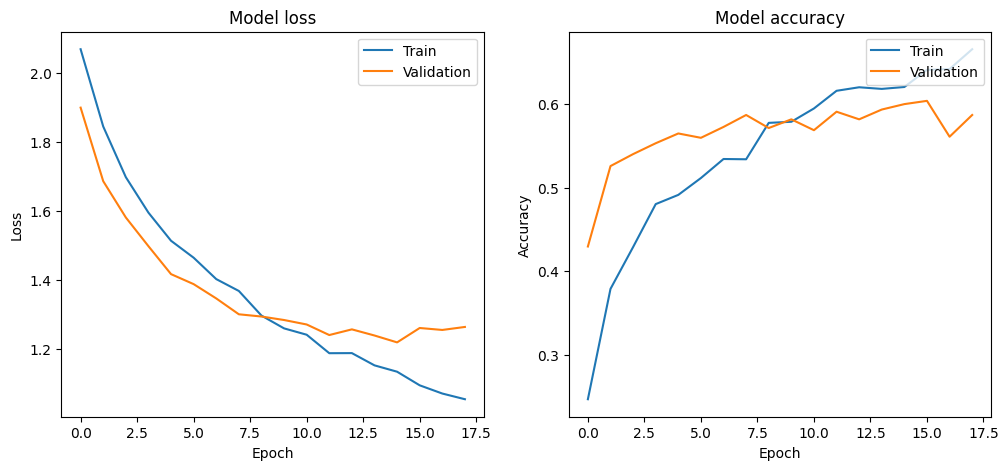

In [18]:
# Ploting

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)


plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

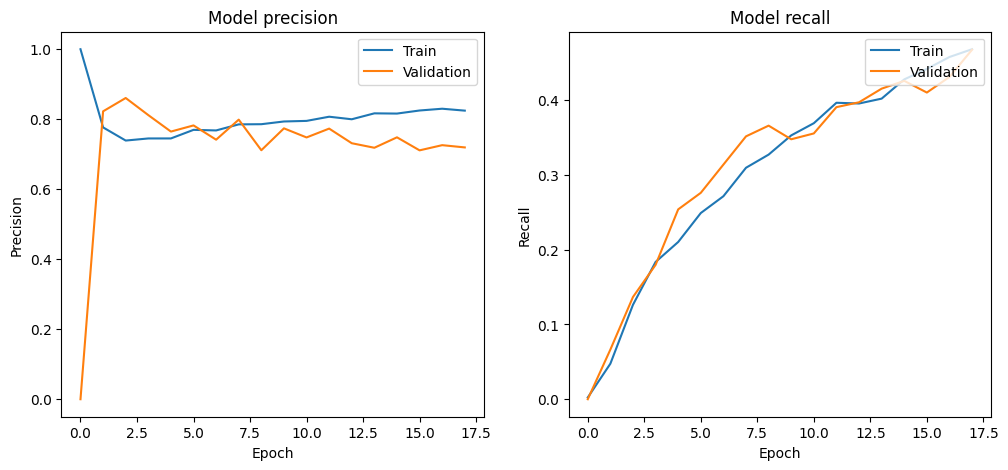

In [20]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1,2,1)
plt.plot(history.history[f'precision'])
plt.plot(history.history[f'val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history[f'recall'])
plt.plot(history.history[f'val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

KeyError: 'precision_4'

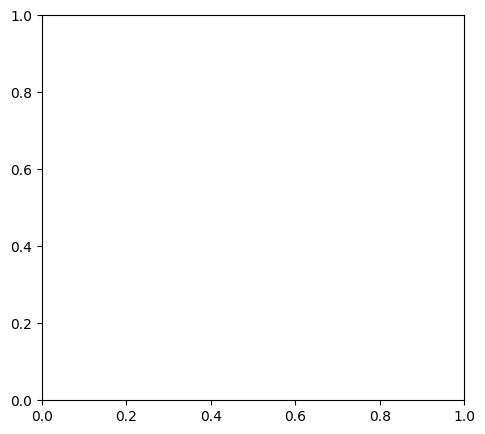

In [19]:
x= 4

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1,2,1)
plt.plot(history.history[f'precision_{x}'])
plt.plot(history.history[f'val_precision_{x}'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history[f'recall_{x}'])
plt.plot(history.history[f'val_recall_{x}'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

### Saved Model eveluation

In [22]:
loaded_model = create_model(input_shape, num_classes)
loaded_model.load_weights("/content/drive/MyDrive/Codes/Saved models/Audio_model_multiclass_new.h5")
loaded_model.summary()

loaded_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
                  loss = losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])

model_check(loaded_model)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,255 (83.03 KB)

 Trainable params: 21,255 (83.03 KB)

 Non-trainable params: 0 (0.00 B)

Evaluate on test data


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - categorical_accuracy: 0.5140 - loss: 1.3982 - precision_1: 0.6395 - recall_1: 0.3831
test loss, test acc: [1.306915521621704, 0.5675675868988037, 0.6910994648933411, 0.44594594836235046]
-2.374834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[[1.08953245e-01 6.04454689e-02 5.38398400e-02 1.41468123e-01
  7.96219781e-02 5.28553650e-02 5.02815962e-01]
 [2.48152465e-02 2.89610848e-02 4.78354692e-01 6.09801747e-02
  2.93077789e-02 2.15921044e-01 1.61659956e-01]
 [7.22143352e-02 1.16617903e-02 2.70901527e-03 2.76508387e-02
  8.27499092e-01 1.07182469e-03 5.71931563e-02]
 [1.65363331e-03 1.55000627e-04 1.60661584e-03 1.32990386e-02
  8.97391001e-04 9.72280860e-01 1.01074744e-02]
 [1.85984328e-01 2.30942830e-03 8.21458641e-03 6.50974751e-01
  5.06790578e-02 4.36641322e-03 9.74714383e-02]
 [1.86131373e-02 3.65957171e-02 2.67271399e-01 6.35811463e-02
  2.53482778e-02 6.79993257e-02 5.20591021e-01]
 [2.16678847e-02 5.40134683e-02 1.09107792e-01 6.19607233e-0